# Foraminifera clusterization
## [GitHub: BenjaminGuzman](https://github.com/BenjaminGuzman)

In [22]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [23]:
SEGMENTED_CROPPED_DIR = os.path.abspath("img/segmented_cropped")
SEGMENTED_DIR = os.path.abspath("img/segmented")

BATCH_SIZE = 20 
EPOCHS = 10

N_IMAGES = 2400 # N IMAGES INSIDE G. Sacculifer, this folder is the one that has less images than the others

## Analyze single image

In [24]:
img = cv2.imread("img/segmented_cropped/G. Bulloides/1.png")
print("---- IMAGE DATA BEFORE SCALING FROM 0 TO 1 ----")
print("Image shape:", img.shape)
print("Image dtype: ", img.dtype)
print("Unique values", np.unique(img))

---- IMAGE DATA BEFORE SCALING FROM 0 TO 1 ----
Image shape: (305, 309, 3)
Image dtype:  uint8
Unique values [  0  33  35  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 167 170]


### Scale and flatten the images
The images set will consist of a matrix
$$
    \begin{equation}
        X = \begin{bmatrix}
            \vdots & \vdots & \cdots & \vdots \\
            x_{n, 1} & x_{n, 2} & \cdots & x_{n, m} \\
            \vdots & \vdots & \cdots & \vdots \\
        \end{bmatrix}
    \end{equation}
$$

where $x_{n, 1}$ is the n'th feature of the 1st sample. Therefore **n** is the number of **features**, while **m** is the number of **samples**.

In [25]:
# Convert to float32 and scale to [0, 1]
img = img.astype(np.float32)
img /= 255

img = img.reshape(-1, 1) # flatten 

print("---- IMAGE DATA BEFORE SCALING FROM 0 TO 1 ----")
print("Image shape:", img.shape)
print("Image dtype: ", img.dtype)
print("Unique values", np.unique(img))

---- IMAGE DATA BEFORE SCALING FROM 0 TO 1 ----
Image shape: (282735, 1)
Image dtype:  float32
Unique values [0.         0.12941177 0.13725491 0.14509805 0.14901961 0.15294118
 0.15686275 0.16078432 0.16470589 0.16862746 0.17254902 0.1764706
 0.18039216 0.18431373 0.1882353  0.19215687 0.19607843 0.2
 0.20392157 0.20784314 0.21176471 0.21568628 0.21960784 0.22352941
 0.22745098 0.23137255 0.23529412 0.23921569 0.24313726 0.24705882
 0.2509804  0.25490198 0.25882354 0.2627451  0.26666668 0.27058825
 0.27450982 0.2784314  0.28235295 0.28627452 0.2901961  0.29411766
 0.29803923 0.3019608  0.30588236 0.30980393 0.3137255  0.31764707
 0.32156864 0.3254902  0.32941177 0.33333334 0.3372549  0.34117648
 0.34509805 0.34901962 0.3529412  0.35686275 0.36078432 0.3647059
 0.36862746 0.37254903 0.3764706  0.38039216 0.38431373 0.3882353
 0.39215687 0.39607844 0.4        0.40392157 0.40784314 0.4117647
 0.41568628 0.41960785 0.42352942 0.42745098 0.43137255 0.43529412
 0.4392157  0.44313726 0.447058

## Load images & convert to greyscale
`SEGMENTED_DIR` contains same shape images but with some black background that could affect later in the learning process, although I think PCA should get rid of such black background.

Also, the max pooling layer(s) of the convnet help to get rid of the background?

In [26]:
species_dirs = os.listdir(SEGMENTED_DIR)# os.listdir(SEGMENTED_CROPPED_DIR)

X_original = [] # the original images
Y = [] # targets

k = 0
for i, specie_dir in enumerate(species_dirs): # the i iterator will be in this case, the target (each directory contains samples for a unique specie)
    specie_dir_abspath = os.path.abspath("{}/{}".format(SEGMENTED_DIR, specie_dir))
    for j, img_file_str in enumerate(os.listdir(specie_dir_abspath)):
        file_path = "{}/{}".format(specie_dir_abspath, img_file_str)
        
        if not os.path.isfile(file_path): # skip trash directories
            continue
            
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (400, 400))
        image = image.astype(np.float32)
        image /= 255
        
        if k >= BATCH_SIZE:
            break
        
        k += 1
        X_original.append(image)
        Y.append(i) # append the specie "index" to Y, expected label
    break # load only first folder

Once the images are loaded it's time to apply PCA to obtain the principal components :), and also get rid of the background (I think that could impact the nn performance)

In [38]:
X_original = np.array(X_original)
print("X original shape", X_original.shape)

X = X_original.reshape(X_original.shape[0], -1).T

print("X flattened shape: (n_features, n_samples): ", X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=0.8)
pca_r3 = PCA(n_components=3)

# TODO: fix this
X_pc = pca.fit_transform(X_scaled.T[:])
print("X flattened with PCA shape: (n_features, n_samples)", X_pc.shape)

#X_viz = pca_r3.fit_transform(X_flattened[:, 0, :])

X original shape (20, 400, 400)
X flattened shape: (n_features, n_samples):  (160000, 20)
X flattened with PCA shape: (n_features, n_samples) (20, 6)


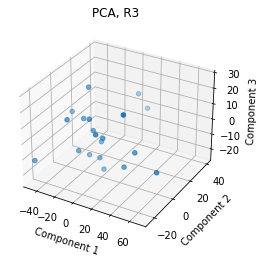

In [14]:
fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.scatter(X_viz[:, 0], X_viz[:, 1], X_viz[:, 2])
axes.set_xlabel("Component 1")
axes.set_ylabel("Component 2")
axes.set_zlabel("Component 3")
axes.set_title("PCA, R3")
plt.show()

## Create ConvNet

In [48]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential, Input, Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

Let's try to train with the raw images, no pca or standarization applied

In [49]:
model = Sequential()
# 32 = # filters (output of conv2D), how to select?
# how to select kernel size?
#shape = (single_image_shape[0], single_image_shape[1], 1)
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(400, 400, 1), data_format="channels_last", activation="relu"))

# how to select factors? in this case will downscale by a factor of 2
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="tanh", padding="same"))
model.add(Flatten())
model.add(Dense(32, activation="tanh"))
model.add(Dense(6, activation="tanh")) # 6 targets, G Bulloides, G. Ruber, G.....
#opt = SGD(lr=0.02)
#model.compile(loss="binary_crossentropy", optimizer = opt, metrics=["accuracy"])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

### Load dataset

In [50]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    #zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.0,  # value used for fill_mode = "constant"
    data_format="channels_last",
    dtype=np.float32,
    rescale=1.0/255,
    validation_split=0.33
)

In [52]:
flow_from_directory = datagen.flow_from_directory(SEGMENTED_DIR, target_size=(400, 400), batch_size=BATCH_SIZE)
    
model.fit_generator(flow_from_directory, epochs=2, steps_per_epoch=N_IMAGES//BATCH_SIZE)

Found 15788 images belonging to 6 classes.
Epoch 1/2


UnimplementedError:  Fused conv implementation does not support grouped convolutions for now.
	 [[node sequential_2/conv2d_4/Relu (defined at <ipython-input-51-bc106c8b4e85>:3) ]] [Op:__inference_train_function_2053]

Function call stack:
train_function


In [33]:
flow_from_directory.class_indices

{'G. Bulloides': 0,
 'G. Ruber': 1,
 'G. Sacculifer': 2,
 'N. Dutertrei': 3,
 'N. Incompta': 4,
 'N. Pachyderma': 5}

In [11]:
model.save("model.h5")

In [12]:
flow_from_directory.__getitem__(0)[0][0].dtype#.shape

dtype('float32')

In [13]:
flow_from_directory.__getitem__(0)[1]

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
image = cv2.imread("img/segmented/G. Bulloides/1073.png")
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (400, 400))
image = image.astype(np.float32)
#image /= 255
x = np.array([image])
print(x.shape)
model.predict(x)
model.predict(flow_from_directory.__getitem__(78)[0], verbose=1)

(1, 400, 400, 3)


In [51]:
import gc
species_dirs = os.listdir(SEGMENTED_DIR)# os.listdir(SEGMENTED_CROPPED_DIR)

scaler = StandardScaler()
pca = PCA(0.9)

n_images = 0

species_dirs_abspath = []
files_abspath_by_specie = []
for specie_dir in species_dirs:
    specie_dir_abspath = os.path.abspath("{}/{}".format(SEGMENTED_DIR, specie_dir))
    species_dirs_abspath.append(specie_dir_abspath)
    files = ["{}/{}".format(specie_dir_abspath, file) for file in os.listdir(specie_dir_abspath) if os.path.isfile("{}/{}".format(specie_dir_abspath, file))]
    files_abspath_by_specie.append(files)

def generate_training_data():
    img_idx = 0
    n_images = 0
    reps = 2
    species_dirs_range = range(len(species_dirs_abspath))
    while n_images <= N_IMAGES:
        X = []
        Y = []
        for i in range(reps):
            for specie_idx in species_dirs_range:
                img_file = files_abspath_by_specie[specie_idx][img_idx]
                image = cv2.imread(img_file)
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, (400, 400))
                image = image.astype(np.float32)
                image /= 255

                #print(img_file, specie_idx)
                #X.append(image.reshape(1, -1))
                X.append(image)
                Y.append(specie_idx) # append the specie "index" to Y, expected label

            img_idx += 1
        
        n_images += 6 * reps
        print("Loaded", n_images, " img last index: ", img_idx)
        
        yield (np.array(X), np.array(Y))

model.fit_generator(generate_training_data(), epochs=3, steps_per_epoch=N_IMAGES/12)
    #print("Training model....")

    #X = np.array(X)
    #Y = np.array(Y)
    # X = scaler.fit_transform(pca.fit_transform(X[:, 0, :]))
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    #print(to_categorical(Y_train).shape)
    #Y_train = to_categorical(Y_train)
    #print(model.train_on_batch(X, Y, reset_metrics=False))#epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    #scores = model.evaluate(X_test, Y_test, verbose=0)
    #print("Saving model")
    #model.save("model.h5")
    

# for i, specie_dir in enumerate(species_dirs):
#     specie_dir_abspath = os.path.abspath("{}/{}".format(SEGMENTED_DIR, specie_dir))
#     gc.collect() # avoid memory overflow
#     last_img_idx = 0
#     images_files = os.listdir(specie_dir_abspath)
#     len_images_files = len(images_files)
#     while last_img_idx < len_images_files:
#         X = []
#         Y = []
#         for j in range(BATCH_SIZE):
#             img_file_str = images_files[last_img_idx + j]
            
#             file_path = "{}/{}".format(specie_dir_abspath, img_file_str)

#             if not os.path.isfile(file_path):
#                 continue

#             image = cv2.imread(file_path)
#             #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#             image = cv2.resize(image, (400, 400))
#             image = image.astype(np.float32)
#             image /= 255

#             X.append(image)
#             Y.append(i) # append the specie "index" to Y, expected label
        
#         j += BATCH_SIZE
        
    
#         print("Loaded images from ", specie_dir_abspath, " last index: ", last_img_idx)
#         print("Training model....")
    
#         X = np.array(X)
#         Y = np.array(Y)
#         # X = scaler.fit_transform(pca.fit_transform(X[:, 0, :]))
#         X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
#         print(to_categorical(Y_train).shape)
#         Y_train = to_categorical(Y_train)
#         model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
#         scores = model.evaluate(X_test, Y_test, verbose=0)
#         print("Saving model")
#         model.save("model.h5")

Epoch 1/3
Loaded 12  img last index:  2
Loaded 24  img last index:  4
Loaded 36  img last index:  6
Loaded 48  img last index:  8
Loaded 60  img last index:  10
Loaded 72  img last index:  12
Loaded 84  img last index:  14
Loaded 96  img last index:  16
Loaded 108  img last index:  18
Loaded 120  img last index:  20
Loaded 132  img last index:  22
Loaded 144  img last index:  24
  1/200 [..............................] - ETA: 12:52 - loss: -22.9999 - accuracy: 0.1667Loaded 156  img last index:  26


KeyboardInterrupt: 

In [158]:
X_original = np.array(X_original)
print("X original shape", X_original.shape)
single_image_shape = X_original[0].shape
print("Single image shape", single_image_shape)

X_pca = pca.fit_transform(X_original[:, 0, :])
X_viz = pca_r3.fit_transform(X_original[:, 0, :])

X original shape (100, 1, 160000)
Single image shape (1, 160000)


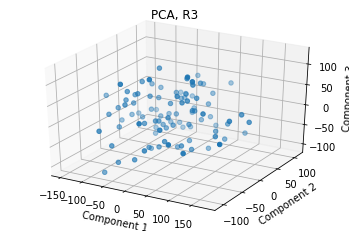

In [159]:
fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.scatter(X_viz[:, 0], X_viz[:, 1], X_viz[:, 2])
axes.set_xlabel("Component 1")
axes.set_ylabel("Component 2")
axes.set_zlabel("Component 3")
axes.set_title("PCA, R3")
plt.show()

### TODO: load, split train & test, preprocess images

In [3]:
BATCH_SIZE = 100

### Load dataset

!This takes about 11.2 Gb on RAM!

In [3]:
species_dirs = os.listdir(SEGMENTED_DIR)# os.listdir(SEGMENTED_CROPPED_DIR)

scaler = StandardScaler()
pca = PCA(0.9)

X = []
Y = []

for i, specie_dir in enumerate(species_dirs):
    specie_dir_abspath = os.path.abspath("{}/{}".format(SEGMENTED_DIR, specie_dir))
    for j, img_file_str in enumerate(os.listdir(specie_dir_abspath)):
        file_path = "{}/{}".format(specie_dir_abspath, img_file_str)
        
        if not os.path.isfile(file_path):
            continue
            
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (400, 400))
        image = image.astype(np.float32)
        image /= 255
        image = scaler.fit_transform(image)
        
        X.append(image.reshape(1, -1))
        Y.append(i) # append the specie "index" to Y, expected label
    
    print("Loaded images from ", specie_dir_abspath)

Loaded images from  /remote/projects/foraminifera/img/segmented/N. Pachyderma
Loaded images from  /remote/projects/foraminifera/img/segmented/G. Sacculifer
Loaded images from  /remote/projects/foraminifera/img/segmented/N. Incompta
Loaded images from  /remote/projects/foraminifera/img/segmented/G. Ruber
Loaded images from  /remote/projects/foraminifera/img/segmented/N. Dutertrei
Loaded images from  /remote/projects/foraminifera/img/segmented/G. Bulloides


### Preprocess

In [ ]:
X = pca.fit_transform(X[:, 0, :])

### Split: train & test dataset

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Create ConvNet

In [147]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [163]:
model = Sequential()
# 32 = # filters (output of conv2D), how to select?
# how to select kernel size?
model.add(Conv2D(32, kernel_size=(5, 5), activation="sigmoid", input_shape=single_image_shape, padding="same"))

# how to select factors? in this case will downscale by a factor of 2
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(6, activation='softmax')) # 6 targets, G Bulloides, G. Ruber, G.....

ValueError: Input 0 is incompatible with layer conv2d_4: expected ndim=4, found ndim=3